# Setup

In [1]:
# Install library for reading JPK File
%pip uninstall jpkreader --yes
%pip install git+https://github.com/jlopezalo/pyjpkreader

Found existing installation: jpkreader 0.0.1
Uninstalling jpkreader-0.0.1:
  Successfully uninstalled jpkreader-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyjpkreader to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-9tf6kxed
  Running command git clone -q https://github.com/jlopezalo/pyjpkreader /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-9tf6kxed
  Created wheel for jpkreader: filename=jpkreader-0.0.1-py3-none-any.whl size=10194 sha256=7257163eff7e463e816749fd2debe6ca2e2a67297a8d9b8461990b558dcd7318
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-0hmmu7ew/wheels/23/c0/8e/c378f28c65b0199f6092b6aa45e090c1ed6b4093f3adb03a15
Successfully built jpkreader
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-_pxo4u2n
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-_pxo4u2n
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=23324 sha256=5794cf07ca7df456cad4d8db7e95d3a67bdbede914f68fe084cb3cdf949fe580
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-uyrl28sh/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from jpkreader import load_jpk_file

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.utils.signal_processing import *
from pyafmrheo.hertz_fit import HertzFit
from pyafmrheo.models.rheology import ComputeComplexModulus

In [21]:
# Define global variables
file_path = '/Users/javierlopez/Desktop/29-06-2021/Petri 1 DMSO +/map-data-2021.06.29-15.05.07.797.jpk-force-map'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
tip_parameter = 75 * 1e-9 # meters
# tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

# Helpful functions

In [29]:
def plot_colormesh(data, cmap):
    fig, ax = plt.subplots()
    xmin = 0; ymin = 0
    xmax = data.shape[0] + 1
    ymax = data.shape[1] + 1
    dx = 1; dy = 1
    x = np.arange(xmin, xmax, dx)
    y = np.arange(ymin, ymax, dy)
    min_val = 0
    max_val = data.max()
    if max_val == 0:
        max_val = 1
    colorm = ax.pcolormesh(x, y, data, cmap=cmap, vmin=min_val, vmax=max_val)
    fig.colorbar(colorm, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.axes.set_aspect('equal')
    plt.xlabel("X pixels")
    plt.ylabel("Y pixels")
    plt.show()

# Read Data

In [30]:
help(load_jpk_file)

Help on function load_jpk_file in module jpkreader:

load_jpk_file(file_path, check_curve_quality=True)



In [31]:
file = load_jpk_file(file_path)

In [32]:
file_id = file.file_id
file_type = file.file_type
file_metadata = file.file_metadata
file_data = file.data
piezo_image = file.piezo_image
quality_map = file.quality_map

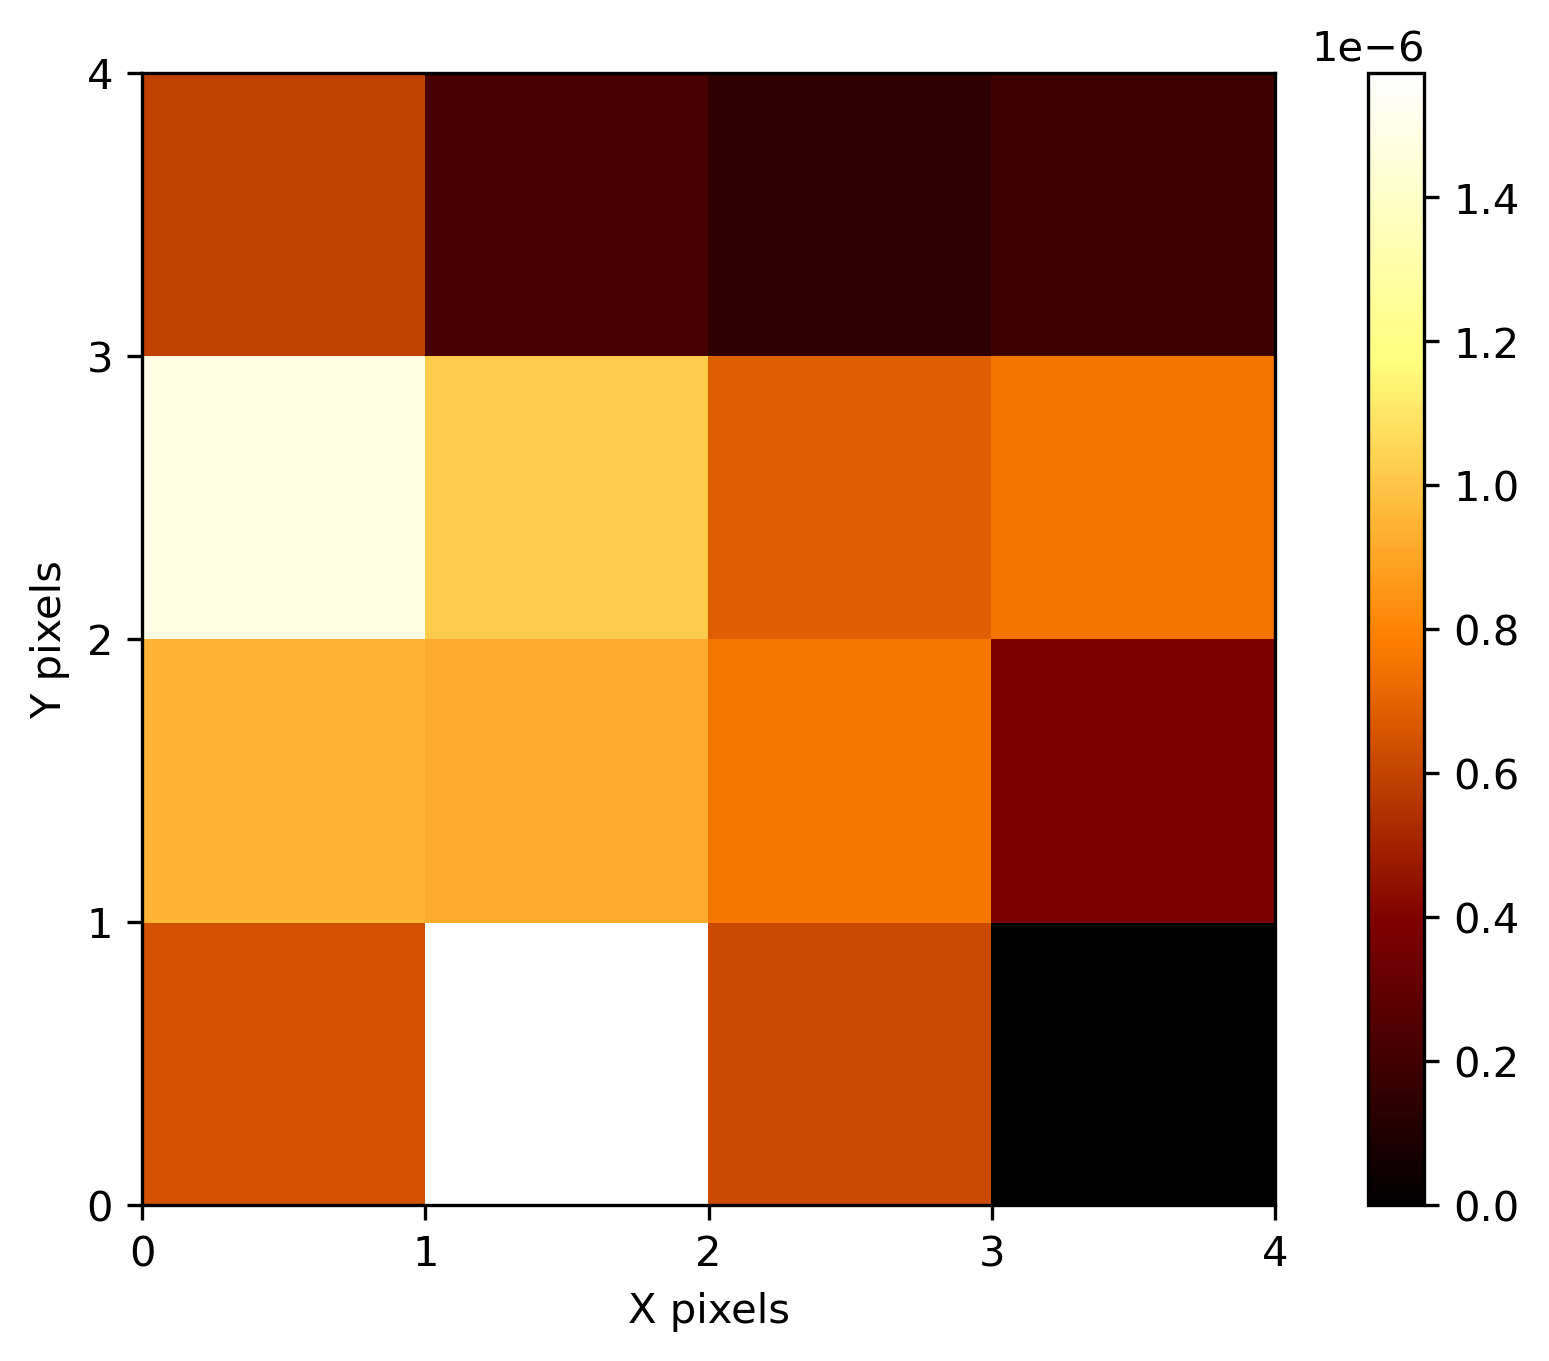

In [34]:
plt.rcParams['figure.dpi'] = 300
if piezo_image is not None:
    plot_colormesh(piezo_image, "afmhot")

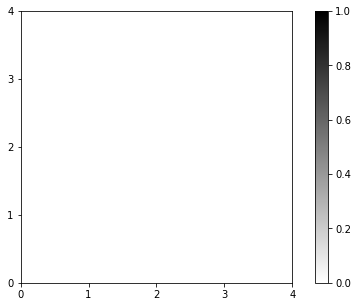

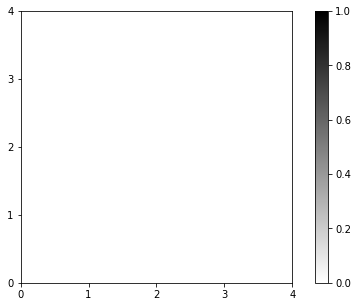

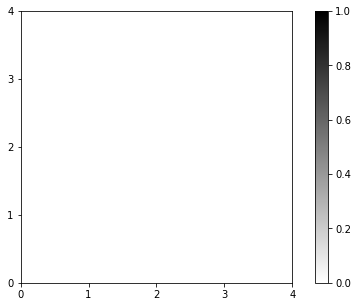

In [27]:
# When the file is loaded 3 quality checks are done on the approach curve:
# 1. Check if the approach curve has less than 10 points
# 2. Check if the slope of the baseline is larger than the slope of the contact part
# 3. Check if the coefficient of variation of the approach baseline deflection is larger than 0.5
# 0 --> Good quality
# 1 --> Bad quality
if piezo_image is not None:
    plot_colormesh(quality_map[:,:,0], "binary")
    plot_colormesh(quality_map[:,:,1], "binary")
    plot_colormesh(quality_map[:,:,2], "binary")
else:
    print(quality_map)

In [97]:
print(file_metadata.keys())

dict_keys(['file_name', 'file_size_bytes', 'file_id', 'instrument', 'file_format_version', 'software_version', 'retracted_delay', 'extended_delay', 'file_date', 'scan_angle', 'num_x_pixels', 'num_y_pixels', 'scan_size_x', 'scan_size_y', 'z_closed_loop_status', 'real_num_pixels', 'extend_pause_duration', 'setpoint', 'nbr_channels', 'original_deflection_sensitivity', 'original_spring_constant', 'channel_properties', 'nbr_segments', 'curve_properties', 'height_channel_key'])


In [31]:
closed_loop = file_metadata['z_closed_loop_status']
file_deflection_sensitivity = file_metadata['original_deflection_sensitivity'] #nm/V
file_spring_constant = file_metadata['original_spring_constant'] #N/m
height_channel = file_metadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [99]:
curve_idx = 4
force_curve = file_data[curve_idx]
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = [*extend_segments, *pause_segments, *modulation_segments, *retract_segments]
force_curve_segments = sorted(force_curve_segments, key=lambda x: int(x[0]))

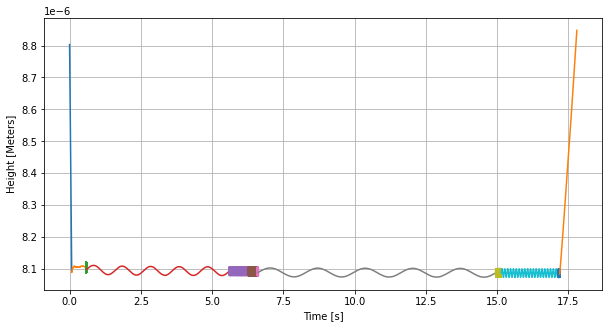

In [100]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

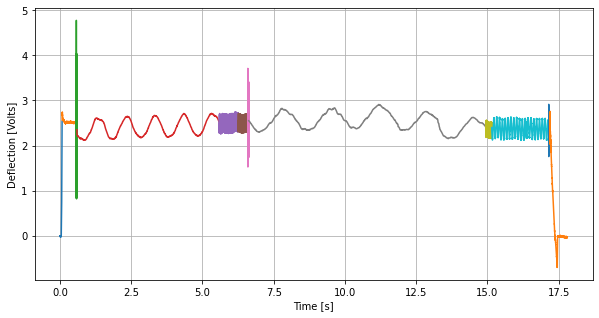

In [101]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

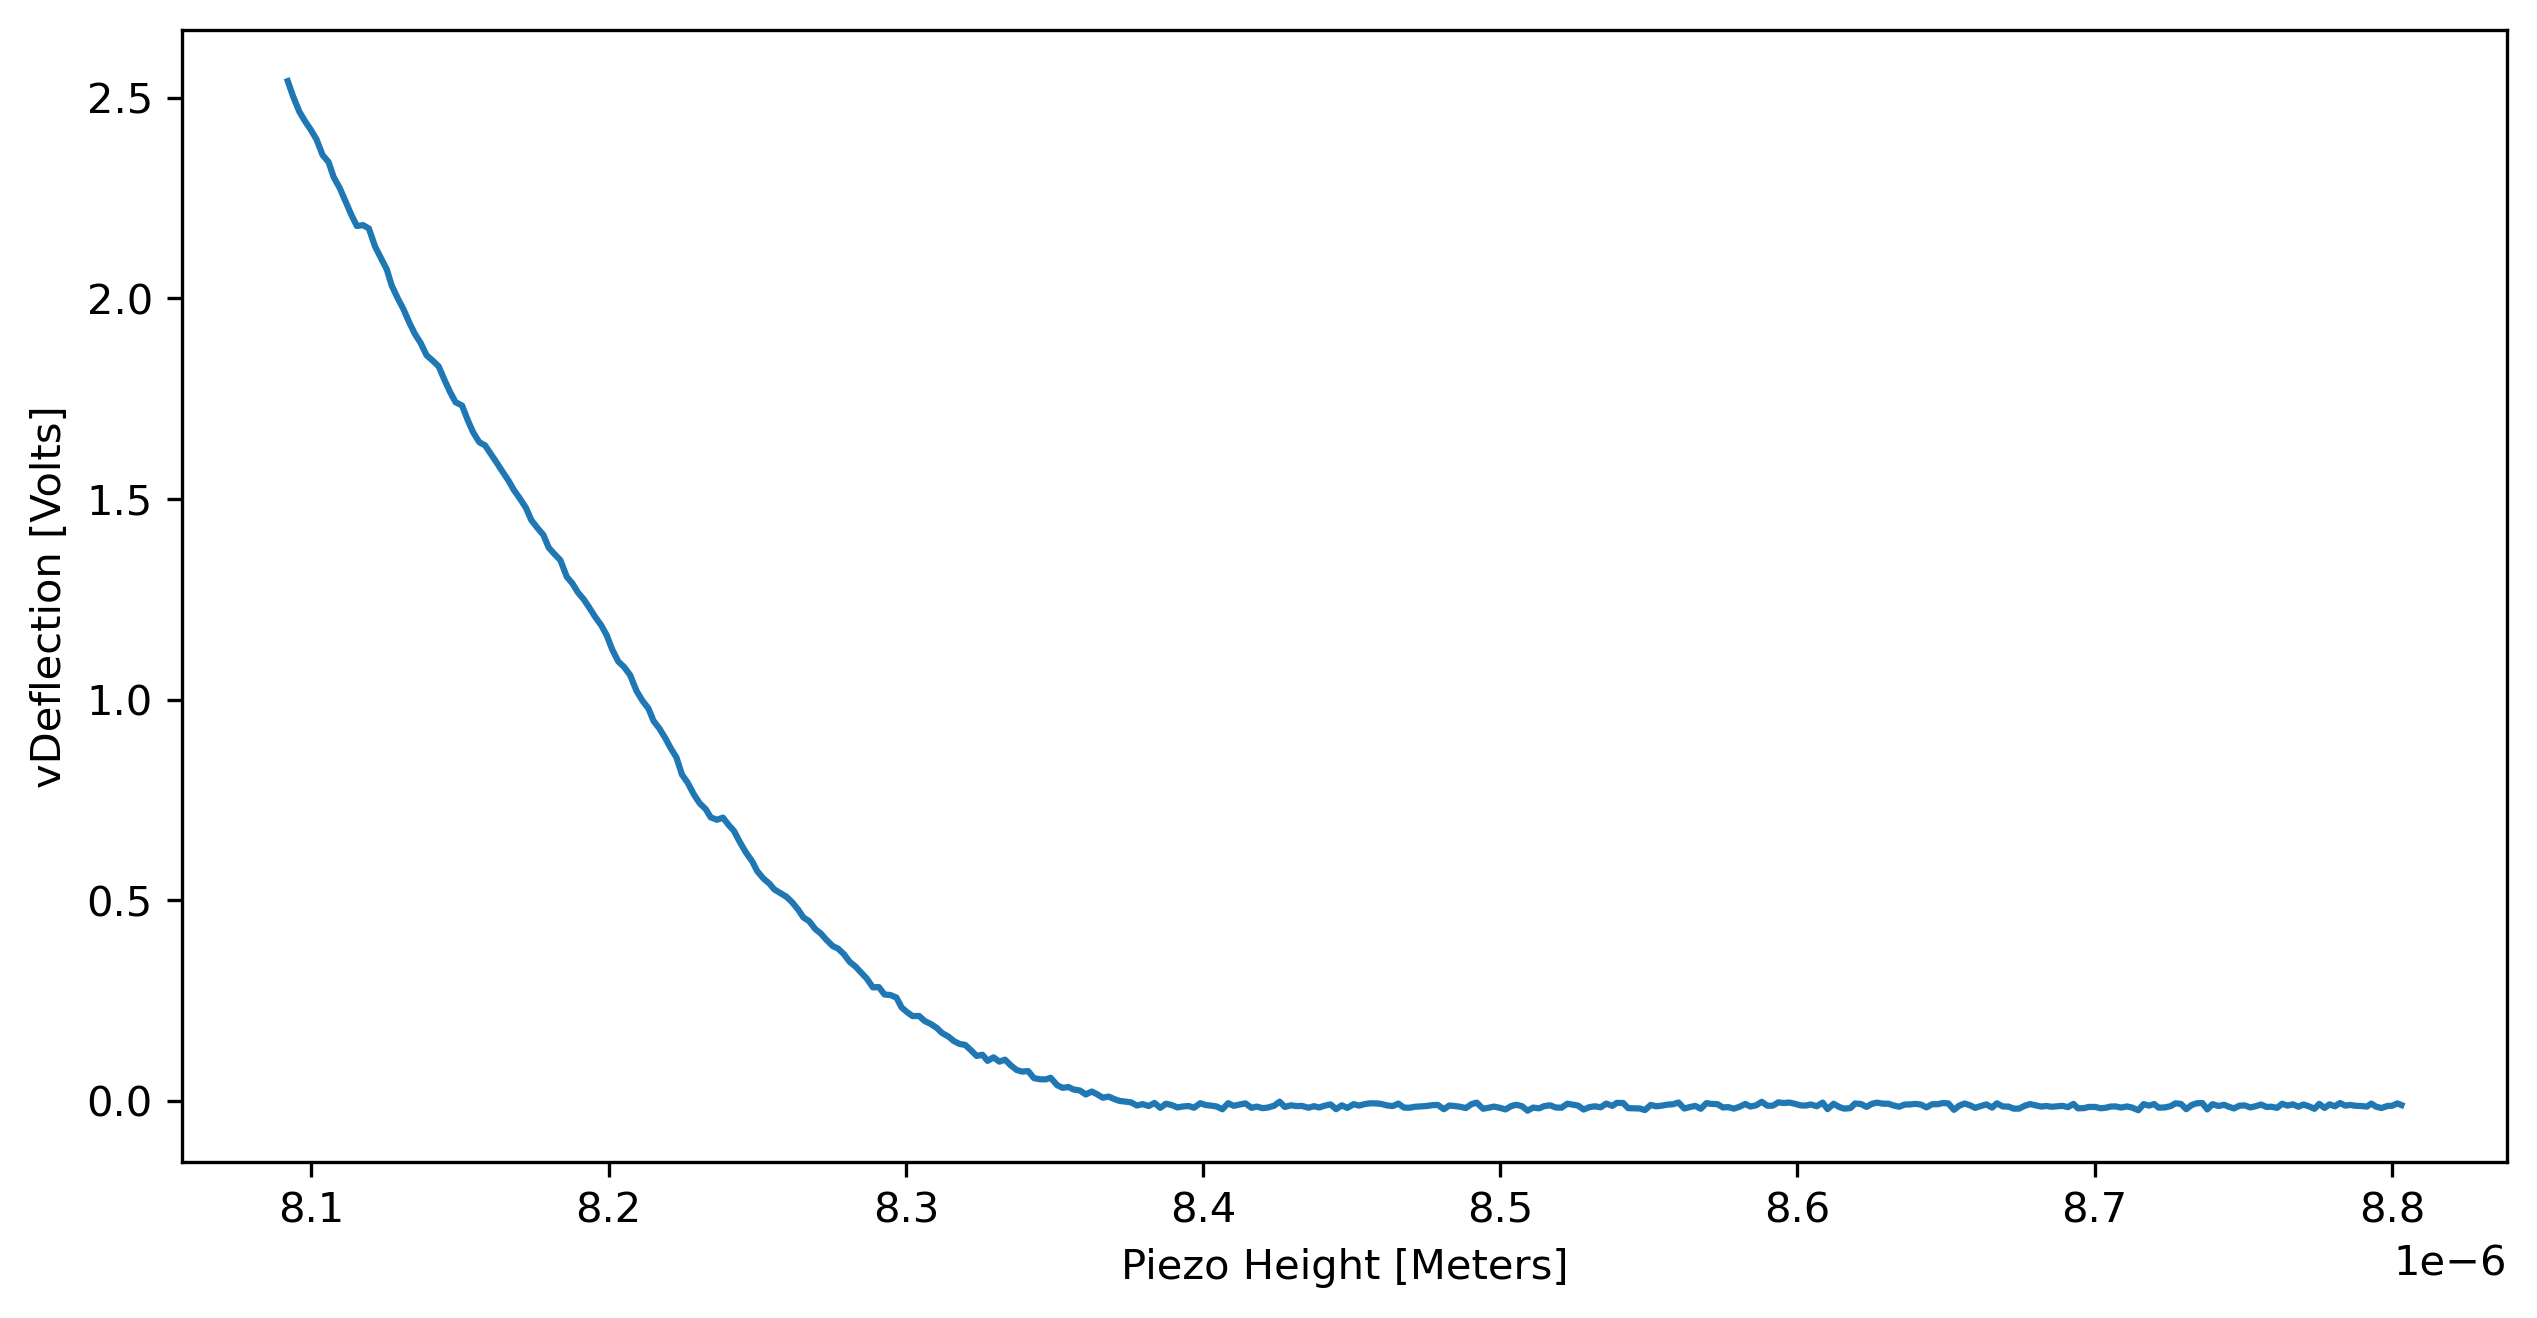

In [105]:
plt.rcParams['figure.dpi'] = 300
for seg_id, segment in extend_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
# plt.grid()
plt.show()

# Preprocess Data

In [46]:
help(preprocess_segment)

Help on function preprocess_segment in module pyafmrheo.utils.force_curves:

preprocess_segment(segment, height_channel_key, deflection_sens, y0=None)



In [37]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
app_deflection, app_height, app_time =\
    preprocess_segment(first_ext_seg, height_channel, deflection_sensitivity)

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
ret_deflection, ret_height, ret_time =\
    preprocess_segment(last_ret_seg, height_channel, deflection_sensitivity)

if pause_segments:
    # Get first pause segment
    first_pause_seg_id, first_pause_seg = pause_segments[0]
    pau_deflection, pau_height, pau_time =\
        preprocess_segment(first_pause_seg, height_channel, deflection_sensitivity)

if modulation_segments:
    modulation_data = {}
    for seg_id, seg_data in modulation_segments:
        segment_data = {}
        mod_deflection, mod_height, mod_time =\
            preprocess_segment(seg_data, height_channel, deflection_sensitivity)
        segment_data['height'] = mod_height
        segment_data['deflection'] = mod_deflection
        segment_data['time'] = mod_time
        modulation_data[seg_id] = segment_data

In [90]:
# Shift height
xzero = ret_height[-1] # Maximum height
app_height = xzero - app_height
ret_height = xzero - ret_height
if pause_segments:
    pau_height = xzero - pau_height
if modulation_segments:
    for segment_data in modulation_data.values():
        segment_data['height'] = xzero - segment_data['height']

In [91]:
help(get_poc_RoV_method)

Help on function get_poc_RoV_method in module pyafmrheo.utils.force_curves:

get_poc_RoV_method(piezo_height, deflection, win_size=20, plot_process=False, savepath='.')
    Compute point of contact using the ratio of variances method.
    Reference: doi: 10.1038/srep21267
    
    Arguments:
    piezo_height -- z position of the piezo in m
    deflection -- deflection of the cantilever in m
    savepath -- path so save the plots showing the results
    win_size -- number of points to include in each window
    plot_plocess -- generate plots
    
    Returns:
    Array containing the values for the PoC [x, y] in m



In [92]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=50)
print(*poc)

4.496363691275578e-07 -1.0355832624189467e-11


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


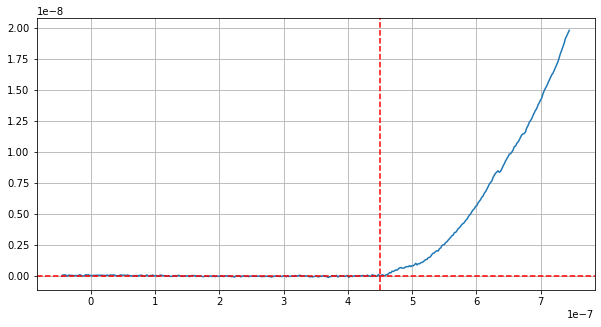

In [93]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

# Process Data: Hertz Fit

Hertz parameter names: ['delta0', 'E0', 'f0', 'slope']
Hertz independent variables: ['indentation']
[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 421
    # variables        = 4
    chi-square         = 6.0595e-19
    reduced chi-square = 1.4531e-21
    Akaike info crit   = -20195.8433
    Bayesian info crit = -20179.6728
##  Warning: uncertainties could not be estimated:
[[Variables]]
    delta0:  9.8751e-09 (init = 0)
    f0:     -3.5351e-11 (init = 0)
    slope:  -1.0392e-04 (init = 0)
    E0:      27972.5846 (init = 100000)


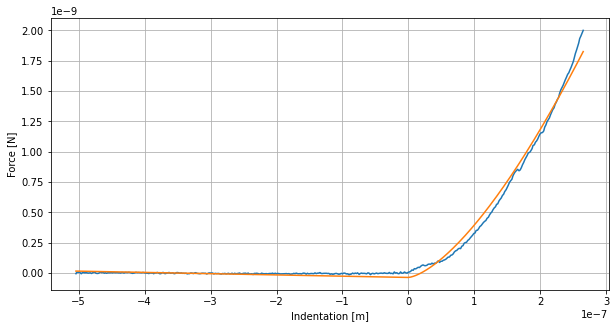

In [94]:
# Hertz fit
poc[1] = 0

app_indentation, app_force = get_force_vs_indentation_curve(app_height, app_deflection, poc, spring_constant)

# Initial parameters
# delta0, f0, slope, E0
p0 = [0, 0, 0, 100000]

hertz_result = HertzFit(app_indentation, app_force, indenter_shape, tip_parameter, p0, poisson_ratio)

hertz_E = hertz_result.best_values['E0']
hertz_d0 = hertz_result.best_values['delta0']

print(hertz_result.fit_report())

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force)
plt.plot(app_indentation-hertz_d0, hertz_result.best_fit)
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.grid()
plt.show()

# Process Data: Microrheology

In [95]:
# Get force vs indentation for all segments
poc[0] += hertz_d0
poc[1] = 0

# Get indentation and force
app_indentation, app_force = get_force_vs_indentation_curve(app_height, app_deflection, poc, spring_constant)
ret_indentation, ret_force = get_force_vs_indentation_curve(ret_height, ret_deflection, poc, spring_constant)
if pause_segments:
    pau_indentation, pau_force = get_force_vs_indentation_curve(pau_height, pau_deflection, poc, spring_constant)
if modulation_segments:
    for segment_data in modulation_data.values():
        mod_indentation, mod_force =\
            get_force_vs_indentation_curve(segment_data['height'], segment_data['deflection'], [0,0], spring_constant)
        segment_data['indentation'] = mod_indentation
        segment_data['force'] = mod_force

# Get working indentation
wc = app_indentation.max()

results = []

for seg_id, seg_data in modulation_segments:
    frequency = seg_data.segment_metadata["frequency"]
    data = modulation_data[seg_id]
    time = data['time']
    indentation = data['indentation']
    force = data['force']
    deltat = time[1] - time[0]
    fs = 1 / deltat
    ntra_in, ntra_out, ntra_time =\
        detrend_rolling_average(frequency, indentation, force, time, 'indentation', 'force', [])
    G_storage, G_loss, gamma2 =\
        ComputeComplexModulus(ntra_out, ntra_in, fs, frequency, indenter_shape, tip_parameter, wc)
    results.append((frequency, G_storage, G_loss, gamma2))

results = sorted(results, key=lambda x: int(x[0]))
frequencies_results = [x[0] for x in results]
G_storage_results = [x[1] for x in results]
G_loss_results = [x[2] for x in results]

TypeError: ComputeComplexModulus() missing 2 required positional arguments: 'tip_parameter' and 'wc'

In [96]:
plt.plot(frequencies_results, G_storage_results, "bo-", label="G'")
plt.plot(frequencies_results, G_loss_results, "r^-", label="G''")
plt.xlabel("Frequency [Hz]")
plt.ylabel("G', G'' [Pa]")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

NameError: name 'frequencies_results' is not defined

In [228]:
print(*G_storage_results)

14972.05944909114 16651.08598422418 13626.051428360464 15030.864062513652 13807.291978338242 9859.774281600347 -7038.051232990415 8049.385116400253 -26305.006225350062


In [229]:
print(*G_loss_results)

2689.6728750390134 1976.2797729493866 1886.475359932651 -1704.3257871378314 -1013.346607499269 995.4471133319504 11243.105224047835 30019.260794622907 195882.76239268415
